#Задача 
Объект описывается уравнением вида  $y(i) = a_1x_1(i)+a_2x_2(i)+a_3x_3(i)+\eta(i)$  
$x_i, i \in{1,2,3}$ - параметры входа, имеющие нормальный закон распределения  
$\eta(i)$ - шум, подчиняющийся распределению Лапласа с хакартеристиками  
$y(i)$ - выход объекта  

По известным входам и выходам объекта оценить парамтры объекта $a_1,a_2,a_3$.  
Данные для тестового моделирования:  
$M(x_1)=10.5, M(x_2)=3.4, M(x_3)=12.6$  
$a_1=2.3,a_2=4.8,a_3=1$

In [367]:
import numpy as np
from scipy import linalg

In [368]:
#@title МНК
def LS(U,R,y):
  Ut = np.transpose(U)
  UtR =  Ut.dot(R)
  UtRU = UtR.dot(U)
  UtRU_inv = np.linalg.inv(UtRU)
  UtRU_invUtR = (UtRU_inv.dot(Ut)).dot(R)
  return UtRU_invUtR.dot(y)

##Генерация входов

In [369]:
U_mean = np.array([10.5,3.4,12.6])
U_var = np.array([10,10,10])
N = 30 # 500 # 
s = 1 # 20 # 

In [370]:
def U_gen(U_mean, U_var, N):
  if len(U_mean) != len(U_var):
    print("Different sizes!")
    return None
  U_vals = list()
  for i in range (len(U_mean)):
    U_vals.append(np.random.normal(loc=U_mean[i], scale = np.sqrt(U_var[i]), size=N))
  return np.transpose(U_vals)

In [371]:
U_val = U_gen(U_mean, U_var, N)

In [372]:
import matplotlib.pyplot as plt

In [373]:
plt.rcParams["figure.dpi"] = 90

In [374]:
def drawU(points, U,label,color, U_mean,mean_label):
  plt.scatter(points, U, label=label, color=color)
  plt.plot([1, N], [U_mean, U_mean], label=mean_label, color=color)


Text(0, 0.5, 'Входное значение, ед.')

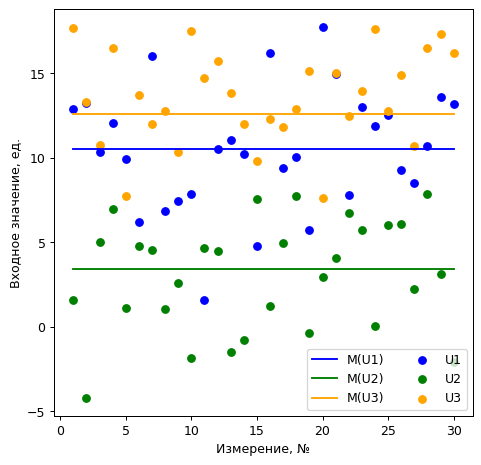

In [375]:
plt.rcParams["figure.figsize"] = (6,6)
points = np.linspace(1,N,N)

drawU(points, U_val[:,0],'U1', 'blue', U_mean[0], 'M(U1)')
drawU(points, U_val[:,1],'U2', 'green', U_mean[1], 'M(U2)')
drawU(points, U_val[:,2],'U3', 'orange', U_mean[2], 'M(U3)')

plt.legend(ncol=2)
plt.xlabel('Измерение, №')
plt.ylabel('Входное значение, ед.')
#None

##Выходы объекта

In [376]:
def y(U,b,e):
  return np.matmul(U,b)+e

In [377]:
a_real = np.array([2.3,4.8,1.])

###Генерация шума

In [378]:
e = np.random.laplace(scale=s, size=N)
e_norm = np.random.normal(scale=s, size=N)

Text(0, 0.5, 'Значение шума, ед.')

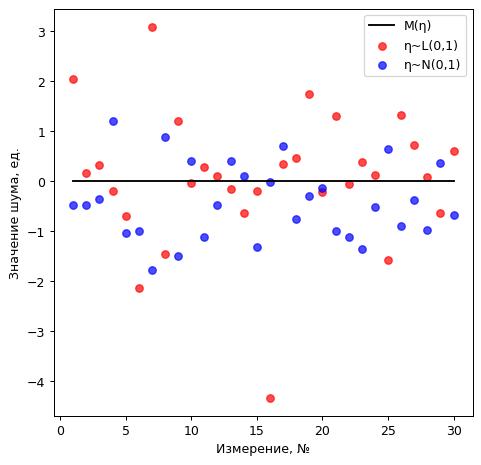

In [379]:
points = np.linspace(1,N,N)

plt.scatter(points, e, label='\u03B7~L(0,1)', color='red', alpha = 0.7)
plt.scatter(points, e_norm, label='\u03B7~N(0,1)', color='blue', alpha = 0.7)
plt.plot([1,N], [0,0], label='M(\u03B7)', color='black')

plt.legend()
plt.xlabel('Измерение, №')
plt.ylabel('Значение шума, ед.')

In [380]:
from scipy.stats import laplace, norm

In [381]:
#ppf - percent point function (inverse of cdf — percentiles)
#cdf - cumulative distribution function
#pdf - probability density function

def drawPdf(ax, func, n_points, func_name, color):
  points = np.linspace(func.ppf(0.0001),
                func.ppf(0.9999), n_points)
  ax.plot(points, func.pdf(points),
       color+'-', lw=1, alpha=0.6, label=func_name)

def drawHist(ax, values, color, name):
  ax.hist(x=values, bins=round(np.log2(N))+1, density=True,  color=color, alpha=0.3, label = name)

In [382]:
fig, ax = plt.subplots(1, 1)

drawPdf(ax, laplace, 500, 'Распределение Лапласа L(0,{})'.format(s), 'r')
drawHist(ax, e, 'r', 'Сгенерированная выборка L(0,{})'.format(s))

drawPdf(ax, norm, 500, 'Нормальное распределение N(0,{})'.format(s), 'b')
drawHist(ax, e_norm, 'b', 'Сгенерированная выборка N(0,{})'.format(s))

ax.legend(loc='upper left', frameon=False)
plt.show()

###Формирование выходов

In [383]:
y_val = y(U_val,a_real,e)

##Оценка параметров

###Метод наименьших модулей

Критерий качества:
$$J(\vec{\tilde{a}}) = \sum_{i=1}^{N}\frac{|y(i)-\tilde{\psi}(x(i),\tilde{a})|}{s(i)}$$

Параметр s распределения Лапласа постоянен для всех $\eta(i)$, поэтому в дальнейшем опускается

####Алгоритм вариационно-взвешенных приближений  
📚 Мудров В.И., Кушко В.Л. М.: Знание. 1971. 

<!-- Критерий качества:
$$J(\vec{a}) = \sum_{i=1}^{N}|y_i-\psi(x_i,a)|$$ -->
Минимизируется взвешенная сумма квадратов:
$$W(a) = \sum_{i=1}^{N}p_{i}(y_i-\psi(x_i,a))^2$$
Веса $p$ являются функцией оценки выхода, а следовательно оценки параметров:
$$p_{i}(a^{(0)}) = \frac{1}{|y_i-\psi(x_i, a^{(0)})|}$$
Тогда $$W(a,a^{(0)}) = \sum_{i=1}^{N}\frac{1}{|y_i-\psi(x_i, a^{(0)})|}(y_i-\psi(x_i,a))^2$$

Свойства $W(a,a^{(0)})$:  
- $W(a,a^{(0)})$ при $a = a^{(0)}$ равно
$$J(\vec{a}) = \sum_{i=1}^{N}|y_i-\psi(x_i,a)|$$
- Если $a^{(1)}$ - значения параметров, при которых достигается минимум $W(a,a^{(0)})$ так, что 
$$W(a^{(1)},a^{(0)})\leq W(a,a^{(0)}),$$ $$то\ J(a^{(1)})\leq J(a^{(0)})$$

"Поскольку в описанном алгоритме на каждом шаге итерационного процесса минимизируется взвешенная квадратическая форма, причем все весовые коэффициенты характеристики изменяются при переходе к каждому очередному шагу, то указанный алгоритм условимся называть алгоритмом вариационно-взвешенных приближений"

##### Начальное приближение
Вычисляется "по минимуму данных", то есть решается система уравнений без избыточных данных

In [384]:
U_min_data = np.array(U_val[:3,:])
Y_min_data = np.array(y_val[:3])

a0 = linalg.solve(U_min_data, Y_min_data)
print(a0)

[1.92327456 4.80356869 1.38983681]


\begin{equation*}
p_i(a^{(0)}) = 
 \begin{cases}
   \displaystyle\frac{1}{|y_i-\psi(x_i, a^{(0)})|}, &|y_i-\psi(x_i, a^{(0)})|\neq0\\
   c_i, &|y_i-\psi(x_i, a^{(0)})|=0
 \end{cases}
\end{equation*}

In [385]:
c = 100

$$\vec{\hat{a}_{LS}}=(U^TRU)^{-1}U^TR\vec{y}$$
$$r_{ii} = p_i$$

In [386]:
from math import isclose

In [387]:
def R_new(N, U, y, a_est, c):
  R = np.zeros((N,N))
  for j in range(N):
    y_est = np.matmul(a_est,U[j,:])
    R[j,j] = c if isclose(y_val[j], y_est, rel_tol=1e-5) else 1/abs(y[j]-y_est)
  return R

In [388]:
def criteria(y, U, a_est, crit):
  criteria_value = 0
  for i in range(len(y)):
    y_est = np.matmul(a_est,U[i,:])
    criteria_value += crit(y[i]-y_est)
  return criteria_value

In [389]:
#dir(list)

In [390]:
def is_need_to_stop(a_old,a_new, eps):
  iter_value = np.max(np.abs(a_new-a_old)/a_old)
  return iter_value < eps, iter_value

In [391]:
R = R_new(N,U_val,y_val,a0,c)
a_old = a0
i = 0
eps = 1e-4
while True:
  a_new = LS(U_val,R,y_val)
  R = R_new(N,U_val,y_val,a_new,c)
  # J_new = criteria(y_val, U_val, a_est, abs)
  stop, stop_value = is_need_to_stop(a_old, a_new, eps)
  print('Итерация {0}:\t{1}\tЗначение критерия останова:\t{2:8.6f}'.format(i, a_new, stop_value))
  if stop:
    break
  else:
    a_old = a_new
    i += 1
a_est = a_new
print('Модульный критерий: {}'.format(criteria(y_val, U_val, a_new, abs)))

Итерация 0:	[1.96567596 4.79969962 1.3498903 ]	Значение критерия останова:	0.028742
Итерация 1:	[2.11946201 4.80805018 1.196692  ]	Значение критерия останова:	0.113489
Итерация 2:	[2.16494452 4.81785779 1.15198851]	Значение критерия останова:	0.037356
Итерация 3:	[2.21706869 4.81176838 1.10138471]	Значение критерия останова:	0.043927
Итерация 4:	[2.26849156 4.81165943 1.05147301]	Значение критерия останова:	0.045317
Итерация 5:	[2.27763504 4.81828479 1.03885366]	Значение критерия останова:	0.012002
Итерация 6:	[2.28956154 4.81957396 1.027076  ]	Значение критерия останова:	0.011337
Итерация 7:	[2.30128159 4.8196866  1.01547127]	Значение критерия останова:	0.011299
Итерация 8:	[2.30542117 4.81878853 1.01080275]	Значение критерия останова:	0.004597
Итерация 9:	[2.30339033 4.8173975  1.01154865]	Значение критерия останова:	0.000881
Итерация 10:	[2.30098333 4.81572175 1.01244191]	Значение критерия останова:	0.001045
Итерация 11:	[2.29827163 4.81379546 1.0134561 ]	Значение критерия останова:

###Метод наименьших квадратов

In [392]:
a_est_LS = LS(U_val,np.eye(N),y_val)
a_est_LS


array([2.27056139, 4.80782491, 1.02812263])

Истинные параметры [2.3, 4.8, 1.0]

In [393]:
# points = np.linspace(1,n_iter,n_iter)
# plt.plot(points, abs_criteria, label='', color='blue')

###Сравнение отклонений оценок параметров от истинных значений

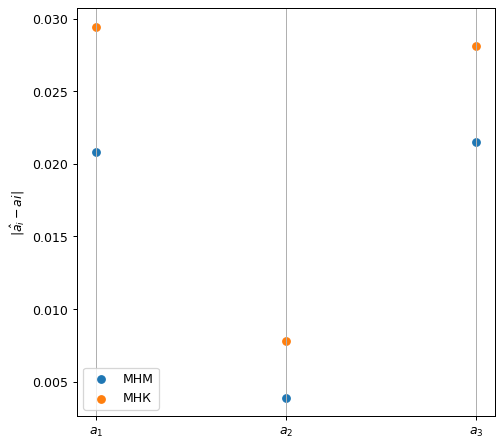

In [394]:
coef_n = [r'$a_1$',r'$a_2$',r'$a_3$']
plt.scatter(coef_n, abs(a_est-a_real), label='МНМ')
plt.scatter(coef_n, abs(a_est_LS-a_real), label='МНК')

plt.xticks(coef_n)
plt.grid(axis='x')
plt.ylabel(r'$|\hat{a_i}-ai|$')
plt.legend(loc='best')
# None

In [395]:
# y_est = np.matmul(U_val,a_est)

# for i in range(len(y_val)):
#   plt.plot([i,i], [y_val[i], y_est[i]], linewidth=3)
# plt.ylim([0, 80])

In [396]:
y_est = np.matmul(U_val,a_est)

plt.scatter(np.linspace(1,N,N), abs(y_val-y_est))
plt.xlabel('Измерение, №')
plt.ylabel('Абс. отклонение модельных выходов от измеренных, ед.')

Text(0, 0.5, 'Абс. отклонение модельных выходов от измеренных, ед.')

##Проверка адекватности модели  
Критерий Манна-Уитни об однородности выборок (непараметрический критерий)

In [397]:
y_real = np.matmul(U_val,a_real)

###Метод наименьших модулей

In [398]:
from scipy import stats

In [399]:
stats.mannwhitneyu(y_real, y_est)

MannwhitneyuResult(statistic=441.0, pvalue=0.4499975186181821)

###Метод наименьших квадратов

In [400]:
y_est_LS =  np.matmul(U_val,a_est_LS)
stats.mannwhitneyu(y_real, y_est_LS)

MannwhitneyuResult(statistic=438.0, pvalue=0.4324968530822437)